In [8]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping



### Import Data

In [9]:
import pandas as pd

madonna_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv')
madonna_df.head()

,Date,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
0,01/01/2012,0.0,5.25,NaN
1,02/01/2012,5.6,6.65,NaN
2,03/01/2012,10.0,8.85,NaN
3,04/01/2012,0.0,6.75,NaN
4,05/01/2012,1.0,5.55,NaN


In [10]:
madonna_df.isnull().sum()
madonna_df = madonna_df.dropna()
print(madonna_df)

            Date  Rainfall_Settefrati  Temperature_Settefrati  \
1167  13/03/2015                  0.0                    5.70   
1168  14/03/2015                  5.8                    7.10   
1169  15/03/2015                  7.4                    4.90   
1170  16/03/2015                  8.6                    7.50   
1171  17/03/2015                  7.6                    7.55   
...          ...                  ...                     ...   
2529  04/12/2018                  0.4                   11.10   
2530  05/12/2018                  0.0                    9.55   
2531  06/12/2018                  0.0                    8.00   
2532  07/12/2018                  0.0                    8.00   
2533  08/12/2018                  8.6                    6.95   

      Flow_Rate_Madonna_di_Canneto  
1167                    255.956525  
1168                    289.545561  
1169                    289.918615  
1170                    290.082896  
1171                    290.688777

### Format Time Series Date Field

In [11]:
from datetime import datetime

original_date = madonna_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
madonna_df['formatted_date'] = pd.to_datetime(madonna_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(madonna_df['formatted_date'])


1167    03/13/2015
1168    03/14/2015
1169    03/15/2015
1170    03/16/2015
1171    03/17/2015
           ...    
2529    12/04/2018
2530    12/05/2018
2531    12/06/2018
2532    12/07/2018
2533    12/08/2018
Name: formatted_date, Length: 879, dtype: object


In [12]:
madonna_df = madonna_df.set_index('formatted_date')
madonna_df = madonna_df.drop(columns=['Date'])
madonna_df.head()

,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
formatted_date,,,
03/13/2015,0.0,5.70,255.956525
03/14/2015,5.8,7.10,289.545561
03/15/2015,7.4,4.90,289.918615
03/16/2015,8.6,7.50,290.082896
03/17/2015,7.6,7.55,290.688777


In [13]:
madonna_df.columns

Index(['Rainfall_Settefrati', 'Temperature_Settefrati',
       'Flow_Rate_Madonna_di_Canneto'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [14]:
target_columns = ['Flow_Rate_Madonna_di_Canneto']
feature_columns = madonna_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [15]:
# Ensure X is defined

def prepare_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_feature_data(madonna_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("madonna_df shape:", madonna_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [16]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 679, Test size: 170


### LSTM Model Multi-Target

In [17]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(1)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Define Early Stopping to precvent Overfitting 

In [18]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)



In [19]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=100,            # Set a high number of epochs; early stopping will stop it earlier if needed
    batch_size=32,         # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1              # Print training progress
)

X_train shape: (679, 30, 2)
y_train shape: (679, 1)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.1633 - val_loss: 0.0949
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0171 - val_loss: 0.1024
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0139 - val_loss: 0.0776
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0149 - val_loss: 0.0841
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0095 - val_loss: 0.0856
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0107 - val_loss: 0.0839
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0128 - val_loss: 0.0952
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0089 - val_loss: 0.0962


### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [20]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.7385633 ]
 [0.7394824 ]
 [0.7383305 ]
 [0.7382401 ]
 [0.7385868 ]
 [0.7389375 ]
 [0.73916334]
 [0.7395384 ]
 [0.7396872 ]
 [0.7397466 ]
 [0.7400203 ]
 [0.7400873 ]
 [0.7403972 ]
 [0.7409439 ]
 [0.7401388 ]
 [0.7396589 ]
 [0.7394229 ]
 [0.73935306]
 [0.73812723]
 [0.7383741 ]
 [0.7388979 ]
 [0.7400784 ]
 [0.74144995]
 [0.7424561 ]
 [0.7433107 ]
 [0.74370015]
 [0.74383295]
 [0.74382097]
 [0.7440481 ]
 [0.7443627 ]
 [0.74310935]
 [0.7435838 ]
 [0.74410033]
 [0.74455214]
 [0.74482405]
 [0.74505067]
 [0.7451681 ]
 [0.74517155]
 [0.7451716 ]
 [0.7454361 ]
 [0.7452749 ]
 [0.74456346]
 [0.74372184]
 [0.74293303]
 [0.7425676 ]
 [0.7423691 ]
 [0.74221206]
 [0.74218774]
 [0.74220854]
 [0.7421472 ]
 [0.7421843 ]
 [0.74240863]
 [0.74262476]
 [0.7422432 ]
 [0.74192834]
 [0.74159217]
 [0.74162906]
 [0.74155307]
 [0.7412046 ]
 [0.7406944 ]
 [0.7403464 ]
 [0.74028516]
 [0.7391658 ]
 [0.73792136]
 [0.73671544]
 [0.7357737 

### Convert back to normal scale

In [21]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

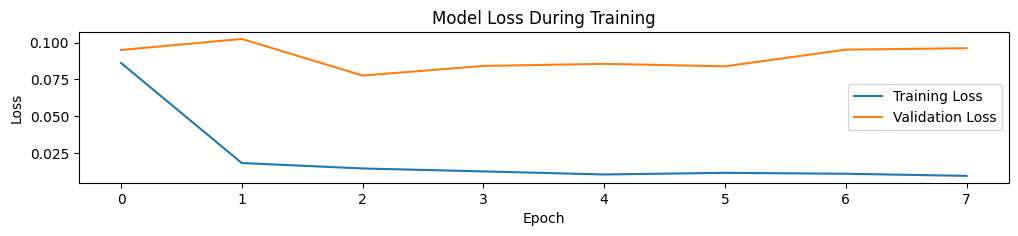

In [22]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [23]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [24]:
evaluate_regression_lstm(y_test_orig, test_pred)


Regression Metrics:
R² Score: -0.1141
MAE: 15.8198
RMSE: 19.3097


(-0.11406705841835563, 15.81978479699219, 19.309664924752205)

## Plot Residuals - Actual vs Predicted

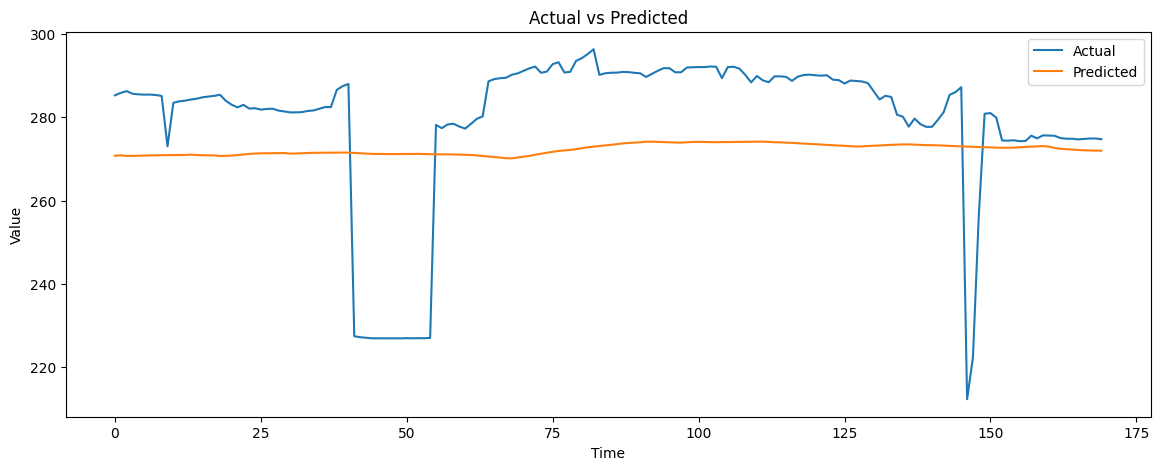

In [25]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig, test_pred)


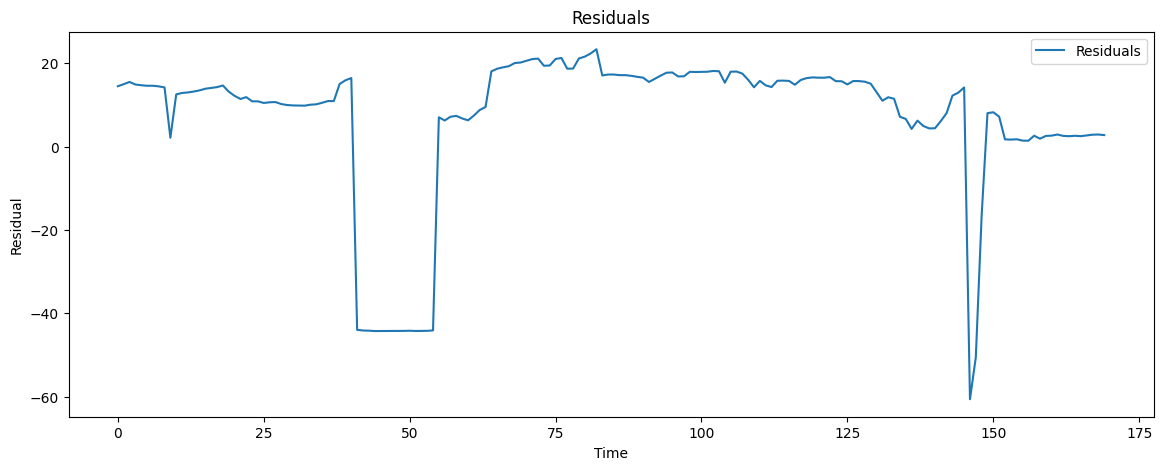

: 

In [26]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')

## Find Optimal Learning Rate 

### Find Optimal Learning Rate 

In [ ]:
def find_optimal_lr(model, X_train, y_train):
    lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
    losses = []
    
    for lr in lr_schedule:
        model.optimizer.learning_rate.assign(lr)
        loss = model.train_on_batch(X_train[:32], y_train[:32])
        losses.append(loss)
        
    best_lr = lr_schedule[np.argmin(losses)]
    return best_lr

find_optimal_lr(model, X_train, y_train)